Checking directories: /kaggle/input/audio-data/Audio_Speech_Actors_01-24, /kaggle/input/audio-data/Audio_Song_Actors_01-24
Total files in speech directory: 1440
Total files in song directory: 1012
Processed 1248 files in /kaggle/input/audio-data/Audio_Speech_Actors_01-24 (speech)


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7c5da95cb420>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error
Exception ignored on calling ctypes callback function: <functio

Processed 1012 files in /kaggle/input/audio-data/Audio_Song_Actors_01-24 (song)
Total files processed: 2260
Processed files by type: {'speech': 1248, 'song': 1012}
Original class distribution: {0: 156, 1: 310, 2: 302, 3: 291, 4: 300, 5: 297, 6: 152}


OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.
OpenBLAS Warning : Detect OpenMP Loop and this application may hang. Please rebuild the library with USE_OPENMP=1 option.


Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.2348 - loss: 15.5595 - val_accuracy: 0.2146 - val_loss: 10.1333 - learning_rate: 0.0010
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3992 - loss: 8.6482 - val_accuracy: 0.1681 - val_loss: 6.6772 - learning_rate: 0.0010
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4513 - loss: 5.6691 - val_accuracy: 0.1681 - val_loss: 5.3874 - learning_rate: 0.0010
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4893 - loss: 4.4945 - val_accuracy: 0.1681 - val_loss: 4.7371 - learning_rate: 0.0010
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5128 - loss: 3.8124 - val_accuracy: 0.1681 - val_loss: 4.3786 - learning_rate: 0.0010
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5467 - loss: 3.3843 - val_accuracy: 0.1681 - val_loss: 4.0233 - learning_rate: 0.0010
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5904 - loss: 2.9331 - va

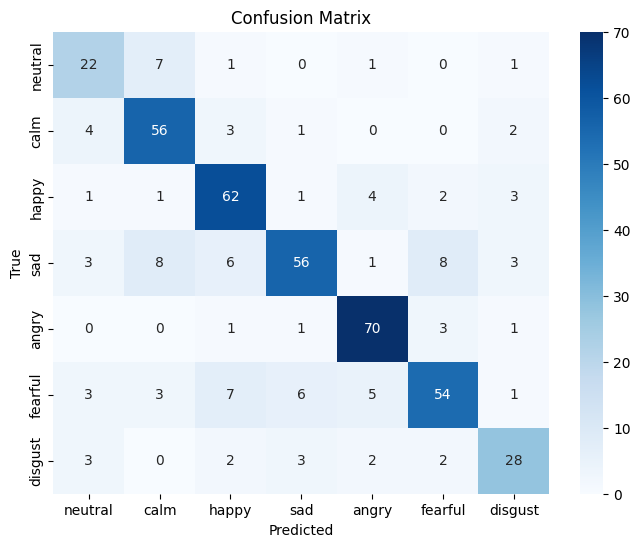

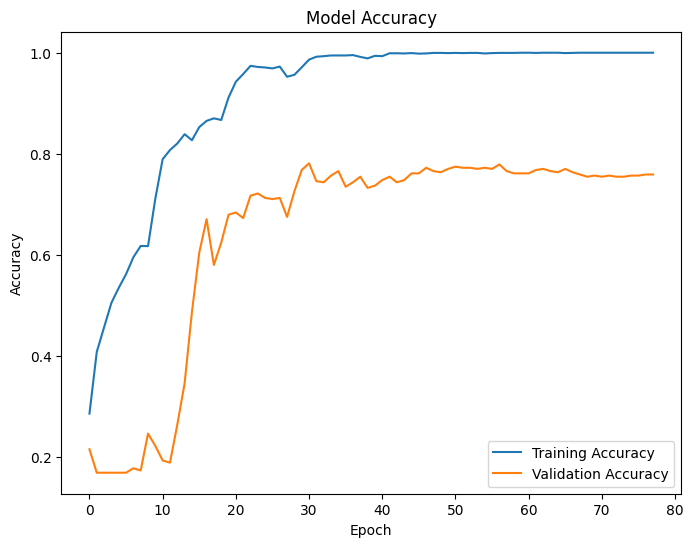

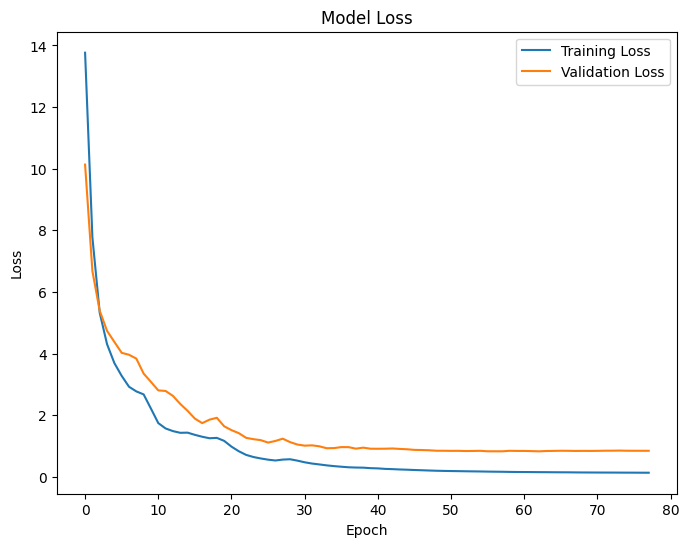

In [ ]:

import os
import numpy as np
import pandas as pd
import librosa
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.regularizers import l2
from imblearn.over_sampling import SMOTE


np.random.seed(42)


data_path = "/kaggle/input/audio-data"
speech_dir = os.path.join(data_path, "Audio_Speech_Actors_01-24")
song_dir = os.path.join(data_path, "Audio_Song_Actors_01-24")


print(f"Checking directories: {speech_dir}, {song_dir}")
if not os.path.exists(speech_dir) or not os.path.exists(song_dir):
    raise ValueError(f"One or both directories not found. Please verify the dataset path: {data_path}")


total_files_speech = sum(len(os.listdir(os.path.join(speech_dir, d))) for d in os.listdir(speech_dir) if os.path.isdir(os.path.join(speech_dir, d)))
total_files_song = sum(len(os.listdir(os.path.join(song_dir, d))) for d in os.listdir(song_dir) if os.path.isdir(os.path.join(song_dir, d)))
print(f"Total files in speech directory: {total_files_speech}")
print(f"Total files in song directory: {total_files_song}")


emotion_dict = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust"
}
selected_emotions = list(emotion_dict.values())


def spec_augment(audio, sr, time_mask=10, freq_mask=5):
    spec = np.abs(librosa.stft(audio))
    time_steps, freq_bins = spec.shape
    if time_mask > 0 and time_steps > time_mask:
        t = np.random.randint(0, time_steps - time_mask)
        spec[:, t:t + time_mask] = 0
    if freq_mask > 0 and freq_bins > freq_mask:
        f = np.random.randint(0, freq_bins - freq_mask)
        spec[f:f + freq_mask, :] = 0
    return librosa.istft(spec)

def extract_features(file_path):
    try:
        audio, sr = librosa.load(file_path, sr=22050)
        audio_aug = spec_augment(audio, sr, time_mask=10, freq_mask=5)
        mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40).T, axis=0)
        delta_mfccs = np.mean(librosa.feature.delta(mfccs), axis=0)
        mfccs_aug = np.mean(librosa.feature.mfcc(y=audio_aug, sr=sr, n_mfcc=40).T, axis=0)
        chroma = np.mean(librosa.feature.chroma_stft(y=audio, sr=sr).T, axis=0)
        mel = np.mean(librosa.feature.melspectrogram(y=audio, sr=sr).T, axis=0)
        audio_pitch = librosa.effects.pitch_shift(audio, sr=sr, n_steps=1.2)
        mfccs_pitch = np.mean(librosa.feature.mfcc(y=audio_pitch, sr=sr, n_mfcc=40).T, axis=0)
        noise = np.random.normal(0, 0.005, audio.shape)
        audio_noisy = audio + noise
        mfccs_noisy = np.mean(librosa.feature.mfcc(y=audio_noisy, sr=sr, n_mfcc=40).T, axis=0)
        audio_intensity = audio * 1.2
        mfccs_intensity = np.mean(librosa.feature.mfcc(y=audio_intensity, sr=sr, n_mfcc=40).T, axis=0)
        return np.hstack([mfccs, delta_mfccs, mfccs_aug, chroma, mel, mfccs_pitch, mfccs_noisy, mfccs_intensity])
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


features = []
labels = []
total_files = 0
processed_files = {"speech": 0, "song": 0}

for base_dir, dir_type in [(speech_dir, "speech"), (song_dir, "song")]:
    file_count = 0
    for actor_dir in os.listdir(base_dir):
        actor_path = os.path.join(base_dir, actor_dir)
        if os.path.isdir(actor_path):
            for filename in os.listdir(actor_path):
                if filename.endswith(".wav"):
                    file_path = os.path.join(actor_path, filename)
                    parts = filename.split("-")
                    if len(parts) >= 3 and parts[2] in emotion_dict:
                        feature = extract_features(file_path)
                        if feature is not None:
                            features.append(feature)
                            labels.append(emotion_dict[parts[2]])
                            file_count += 1
                            total_files += 1
                            processed_files[dir_type] += 1
    print(f"Processed {file_count} files in {base_dir} ({dir_type})")

print(f"Total files processed: {total_files}")
print(f"Processed files by type: {processed_files}")


if not features:
    raise ValueError("No features extracted. Check dataset or file access.")
X = np.array(features)
y = np.array([selected_emotions.index(label) for label in labels])


os.makedirs("/kaggle/working/models", exist_ok=True)


scaler = StandardScaler()
X = scaler.fit_transform(X)


joblib.dump(scaler, "/kaggle/working/models/scaler.pkl")


X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


X_train_reshaped = X_train.reshape(X_train.shape[0], -1)

class_counts = np.bincount(y_train)
print("Original class distribution:", {i: count for i, count in enumerate(class_counts) if count > 0})

majority_class_size = np.max(class_counts)
target_size = int(majority_class_size * 2.5)  
smote = SMOTE(sampling_strategy={selected_emotions.index("sad"): target_size, selected_emotions.index("fearful"): target_size}, random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_reshaped, y_train)
X_train_cnn = X_train_res.reshape(X_train_res.shape[0], X_train_res.shape[1], 1)
X_val_cnn = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)


y_train_cat = to_categorical(y_train_res, num_classes=len(selected_emotions))
y_val_cat = to_categorical(y_val, num_classes=len(selected_emotions))


class_weights = compute_class_weight('balanced', classes=np.unique(y_train_res), y=y_train_res)
class_weight_dict = dict(enumerate(class_weights))


model = Sequential([
    Conv1D(64, 3, activation="relu", input_shape=(X_train_res.shape[1], 1), kernel_regularizer=l2(0.02)),
    BatchNormalization(),
    MaxPooling1D(2),
    Conv1D(128, 3, activation="relu", kernel_regularizer=l2(0.02)),
    BatchNormalization(),
    MaxPooling1D(2),
    Flatten(),
    Dense(256, activation="relu", kernel_regularizer=l2(0.02)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation="relu", kernel_regularizer=l2(0.02)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(len(selected_emotions), activation="softmax")
])


class_weights_loss = np.array([1.0, 1.0, 1.0, 2.5, 1.0, 2.5, 1.0])  
def weighted_hybrid_loss(alpha=0.7):
    def weighted_hybrid_loss_fn(y_true, y_pred):
        y_true = K.cast(y_true, 'float32')
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        
        weights = K.constant(class_weights_loss)
        weights = K.tile(K.expand_dims(weights, 0), [K.shape(y_true)[0], 1])
        weighted_pred = y_pred * weights
        ce_loss = K.categorical_crossentropy(y_true, weighted_pred)
        
        fl_loss = focal_loss(gamma=2.0, alpha=0.3)(y_true, y_pred)
        return alpha * ce_loss + (1 - alpha) * fl_loss
    return weighted_hybrid_loss_fn
def focal_loss(gamma=2.0, alpha=0.3):
    def focal_loss_fn(y_true, y_pred):
        y_true = K.cast(y_true, 'float32')
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        ce_loss = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1.0 - y_pred, gamma)
        fl_loss = weight * ce_loss
        return K.sum(fl_loss, axis=-1)  
    return focal_loss_fn
model.compile(optimizer="adam", loss=weighted_hybrid_loss(alpha=0.7), metrics=["accuracy"])


def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lr = initial_lr * np.power(drop, np.floor((1 + epoch) / epochs_drop))
    return max(lr, 1e-6)


early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=0.0001)
lr_scheduler = LearningRateScheduler(lr_schedule)
history = model.fit(X_train_cnn, y_train_cat, epochs=100, batch_size=64, validation_data=(X_val_cnn, y_val_cat), callbacks=[early_stopping, reduce_lr, lr_scheduler], class_weight=class_weight_dict)


y_val_pred = model.predict(X_val_cnn).argmax(axis=1)
f1 = f1_score(y_val, y_val_pred, average="weighted")
acc = accuracy_score(y_val, y_val_pred)
print(f"Validation F1 Score: {f1:.2f}")
print(f"Validation Accuracy: {acc:.2f}")


cm = confusion_matrix(y_val, y_val_pred)
class_acc = cm.diagonal() / cm.sum(axis=1)
for i, emotion in enumerate(selected_emotions):
    print(f"{emotion} Accuracy: {class_acc[i]:.2f}")


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=selected_emotions, yticklabels=selected_emotions)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


model.save("/kaggle/working/models/emotion_classifier.h5")


plt.figure(figsize=(8, 6))
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()